In [217]:
# Efficient Frontier  - Markowitz

#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

from tqdm import tqdm
import seaborn as sns

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff


In [142]:
# Import Data
# 5 stocks + risk-free bond from 02/06/20 to 30/12/22 
# data are the log-normal daily returns
data_daily = pd.read_csv('data2_1.csv', index_col=0)
data_daily.head()


,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L
Date,,,,,,,,,,
02/06/20,-0.001855,-0.018788,-0.006763,-0.011465,0.009639,0.011500,-0.012039,0.034085,-0.002516,0.055048
03/06/20,0.020903,0.006302,0.008446,0.026435,0.024219,0.043231,0.014954,0.055731,0.011784,0.032043
04/06/20,0.000227,-0.007708,-0.008082,-0.004155,-0.018268,-0.005991,-0.002331,0.003696,0.004238,-0.009178
05/06/20,0.002044,-0.012148,-0.008270,0.006226,-0.027063,0.057291,0.006977,0.047827,0.013038,0.074628
08/06/20,-0.003408,-0.027307,0.001830,-0.005533,0.022816,-0.005215,-0.003192,0.036870,0.015424,0.009615


In [143]:
# Annaulized mean returns
# 252 trading days in a year
annual_mean = (1+data_daily.mean())**252-1
print('Annual mean')
print(annual_mean)


Annual mean
ULVR.L    0.023343
AZN.L     0.129852
GSK.L    -0.000265
DGE.L     0.126754
NG.L      0.089960
HSBA.L    0.162147
SGE.L     0.055189
LLOY.L    0.197327
VOD.L    -0.092221
BP.L      0.238943
dtype: float64


In [144]:
# Get covariance
cov = data_daily.cov()*252
cov = round(cov, 2)
print('Covariance matrix')
print(cov)

Covariance matrix
        ULVR.L  AZN.L  GSK.L  DGE.L  NG.L  HSBA.L  SGE.L  LLOY.L  VOD.L  BP.L
ULVR.L    0.05   0.01   0.02   0.02  0.02    0.01   0.01    0.01   0.01  0.00
AZN.L     0.01   0.06   0.03   0.02  0.02    0.01   0.01    0.01   0.01  0.01
GSK.L     0.02   0.03   0.05   0.02  0.02    0.02   0.01    0.01   0.01  0.02
DGE.L     0.02   0.02   0.02   0.05  0.02    0.03   0.02    0.03   0.02  0.02
NG.L      0.02   0.02   0.02   0.02  0.04    0.01   0.01    0.01   0.02  0.01
HSBA.L    0.01   0.01   0.02   0.03  0.01    0.10   0.01    0.07   0.03  0.06
SGE.L     0.01   0.01   0.01   0.02  0.01    0.01   0.07    0.01   0.01  0.00
LLOY.L    0.01   0.01   0.01   0.03  0.01    0.07   0.01    0.12   0.03  0.06
VOD.L     0.01   0.01   0.01   0.02  0.02    0.03   0.01    0.03   0.06  0.04
BP.L      0.00   0.01   0.02   0.02  0.01    0.06   0.00    0.06   0.04  0.13


In [280]:
# Random Portfolios
# Asses to include in each portfolio
n_assets = data_daily.shape[1]
# Portfolios to generate
n_portfolios = 1000

# mean variance pairs (plot purposes)
mean_variance_pairs = []
weights_list = []
tickers_list = []

np.random.seed(4321) #random seed

# Portfolio random generator
for i in range(n_portfolios):
    # Choose assets randomdly
    assets = list(data_daily.columns)

    # Choose weights randomly
    weights = np.random.rand(n_assets)
    # Weights sum to 1
    weights = weights/sum(weights) #proportion of the asset

    # Additional loop over assets pairs
    # Compute portfolio return and variance
    portfolio_var = 0
    portfolio_return = 0
    for i in range(len(assets)):
        portfolio_return += weights[i] * annual_mean.loc[assets[i]]
        for j in range(len(assets)):
            # Add variance (when i==j) / covariance for each pair
            portfolio_var += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
        
    # mean / variance pairs to a list (plot)
    mean_variance_pairs.append([portfolio_return, portfolio_var])
    weights_list.append(weights)
    tickers_list.append(assets)
    


In [281]:
# Plot risk vs. return of the randomly portfolios
# Convert the list into an array
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate = 0.0152

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualized Risk (Volatility)'),
                  yaxis=dict(title='Annualized Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_layout(yaxis_range=[0.0,0.17])
fig.update_layout(xaxis_range=[0.09, 0.23])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))


In [181]:
# Sample only from efficient frontier
n_assets = data_daily.shape[1]

mean_variance_pairs = []
weights_list = []
tickers_list = []
np.random.seed(4321) #random seed

for i in tqdm(range(1000)):
    next_i = False
    while True:
        assets = list(data_daily.columns)
        weights = np.random.rand(n_assets)
        weights = weights / sum(weights)

        portfolio_return = 0
        portfolio_var = 0
        for i in range(len(assets)):
            portfolio_return += weights[i] * annual_mean[assets[i]]
            for j in range(len(assets)):
                portfolio_var += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
        

        for R, V in mean_variance_pairs:
            if (R>portfolio_return) & (V<portfolio_var):
                next_i = True
                break
        if next_i:
            break

        mean_variance_pairs.append([portfolio_return, portfolio_var])
        weights_list.append(weights)
        tickers_list.append(assets)
        break


100%|██████████| 1000/1000 [00:00<00:00, 1396.92it/s]


In [182]:
# How many portfolios are in the efficient frontier
len(mean_variance_pairs)

73

In [184]:
# Plot the risk vs. return of the portfolios
# Convert the list into an array
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate = 0.0152

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualized Risk (Volatility)'),
                  yaxis=dict(title='Annualized Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_layout(yaxis_range=[0.02,0.17])
fig.update_layout(xaxis_range=[0.09, 0.23])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))


In [84]:
# Data Frame for the weights list
#dff = pd.DataFrame()
columns = ['ULVR.L', 'AZN.L','GSK.L','DGE.L','NG.L','HSBA.L','SGE.L','LLOY.L','VOD.L','BP.L' ]
dff = pd.DataFrame(np.array(weights_list).round(2), columns=columns)
dff.index += 1

In [85]:
# Data frame for the annaulised return and risk
d = {'Annualized Return': np.array(mean_variance_pairs[:,0]).round(4), 'Annualized Risk': np.array(mean_variance_pairs[:,1]**0.5).round(4), 'Sharpe Ratio': np.array(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5)}
results = pd.DataFrame(d)
results.index += 1


In [86]:
# Merge both data frames
total = pd.concat([results, dff], axis = 1)
total

,Annualized Return,Annualized Risk,Sharpe Ratio,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L
1,0.1192,0.1772,0.586967,0.02,0.17,0.16,0.06,0.04,0.21,0.09,0.16,0.02,0.07
2,0.1084,0.1663,0.560161,0.12,0.09,0.04,0.13,0.13,0.18,0.05,0.12,0.07,0.08
3,0.0714,0.1554,0.361322,0.19,0.19,0.19,0.08,0.07,0.13,0.01,0.05,0.09,0.02
4,0.0730,0.1506,0.383840,0.15,0.17,0.03,0.02,0.05,0.01,0.17,0.12,0.18,0.10
5,0.1117,0.1708,0.564634,0.07,0.05,0.11,0.06,0.09,0.14,0.15,0.18,0.04,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.1295,0.1639,0.697262,0.04,0.19,0.04,0.05,0.15,0.11,0.14,0.04,0.02,0.22
70,0.1109,0.1542,0.620426,0.12,0.15,0.11,0.05,0.13,0.05,0.13,0.14,0.00,0.12
71,0.1610,0.2233,0.652998,0.03,0.04,0.02,0.10,0.02,0.25,0.07,0.27,0.02,0.19
72,0.1349,0.1679,0.713133,0.01,0.14,0.01,0.06,0.18,0.14,0.18,0.15,0.00,0.12


In [87]:
# Download the 'total' dataframe to a cvs
csv_file_path = 'total.csv'
total.to_csv(csv_file_path, index=False)
print(f"DataFrame has been saved to '{csv_file_path}' as a CSV file.")

DataFrame has been saved to 'total.csv' as a CSV file.


In [88]:
# Import Data
# 10 stocks from 04/01/17 to 29/11/19 
# + FTSE-100 prices (market prices)
# data are daily prices
data = pd.read_csv('data2_2.csv')
data.head()

,Date,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L,FTSE-100
0,01/06/20,3838.408936,8038.653320,1396.977661,2625.459717,772.820923,329.899078,634.954773,27.126764,101.719322,264.721802,6166.42
1,02/06/20,3831.294678,7889.036133,1387.562378,2595.530273,780.306274,333.714935,627.356079,28.067324,101.463730,279.702850,6220.14
2,03/06/20,3912.224609,7938.908691,1399.331299,2665.057861,799.435608,348.458069,636.808044,29.675941,102.666458,288.810638,6382.41
3,04/06/20,3913.113525,7877.954102,1388.066895,2654.007080,784.963806,346.376678,635.325378,29.785814,103.102440,286.171997,6341.44
4,05/06/20,3921.118652,7782.828613,1376.634399,2670.583252,764.004883,366.800293,639.773499,31.245003,104.455498,308.345642,6484.30


In [89]:
# Normalize stock data based on the intial price
def normalize(df):
    x = df.copy()
    for i in x.columns[1:]:
        x[i] = np.log(x[i]/x[i][0])
    return x

In [138]:
# Interactive plot
def interative_plot(df):
    fig = go.Figure()
    fig = px.line(title = 'Log-normalized Prices')
    for i in df.columns[1:]:
        fig.add_scatter(x = df['Date'], y = df[i], name = i)
    fig.show()

interative_plot(normalize(data))


In [91]:
# Interactive plot - Daily prices
def interative_plot(df):
    fig = go.Figure()
    fig = px.line(title = 'Daily Prices')
    for i in df.columns[1:]:
        fig.add_scatter(x = df['Date'], y = df[i], name = i)
    fig.show()

interative_plot((data))

In [92]:
# Correlation matrix
corr = data.corr(method = 'pearson')
corr = round(corr, 2)
corr

,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L,FTSE-100
ULVR.L,1.00,-0.23,-0.51,-0.56,-0.53,-0.60,-0.04,-0.60,-0.63,-0.40,-0.62
AZN.L,-0.23,1.00,0.69,0.68,0.81,0.74,0.57,0.46,0.03,0.85,0.59
GSK.L,-0.51,0.69,1.00,0.61,0.83,0.65,0.46,0.43,0.40,0.55,0.58
DGE.L,-0.56,0.68,0.61,1.00,0.82,0.84,0.62,0.91,0.30,0.79,0.94
NG.L,-0.53,0.81,0.83,0.82,1.00,0.85,0.54,0.65,0.39,0.74,0.78
HSBA.L,-0.60,0.74,0.65,0.84,0.85,1.00,0.33,0.80,0.52,0.87,0.87
SGE.L,-0.04,0.57,0.46,0.62,0.54,0.33,1.00,0.44,-0.29,0.52,0.47
LLOY.L,-0.60,0.46,0.43,0.91,0.65,0.80,0.44,1.00,0.41,0.69,0.95
VOD.L,-0.63,0.03,0.40,0.30,0.39,0.52,-0.29,0.41,1.00,0.15,0.47
BP.L,-0.40,0.85,0.55,0.79,0.74,0.87,0.52,0.69,0.15,1.00,0.77


Correlation between stocks in the portfolio


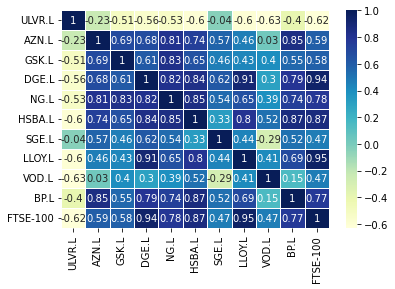

In [93]:
# Plot correlation matrix
fig2 = plt.figure()
sb.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns,
cmap='YlGnBu', annot=True, linewidth=0.5)
print('Correlation between stocks in the portfolio')
plt.show(fig2)

In [94]:
# Data of the log-return of the stocks and index
# Import Data
# 10 stocks + risk-free bond from 02/06/20 to 30/12/22 
# data are the log-normal daily returns
stocks_data = pd.read_csv('data2_3.csv', index_col=0)
stocks_data.head()

,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L,FTSE-100
Date,,,,,,,,,,,
02/06/20,-0.001855,-0.018788,-0.006763,-0.011465,0.009639,0.011500,-0.012039,0.034085,-0.002516,0.055048,0.008674
03/06/20,0.020903,0.006302,0.008446,0.026435,0.024219,0.043231,0.014954,0.055731,0.011784,0.032043,0.025753
04/06/20,0.000227,-0.007708,-0.008082,-0.004155,-0.018268,-0.005991,-0.002331,0.003696,0.004238,-0.009178,-0.006440
05/06/20,0.002044,-0.012148,-0.008270,0.006226,-0.027063,0.057291,0.006977,0.047827,0.013038,0.074628,0.022278
08/06/20,-0.003408,-0.027307,0.001830,-0.005533,0.022816,-0.005215,-0.003192,0.036870,0.015424,0.009615,-0.001808


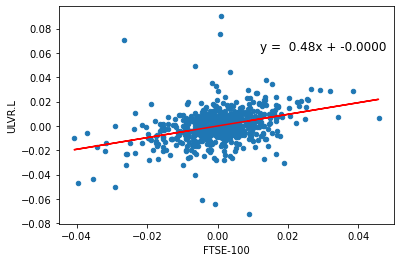

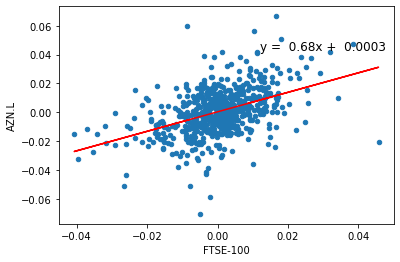

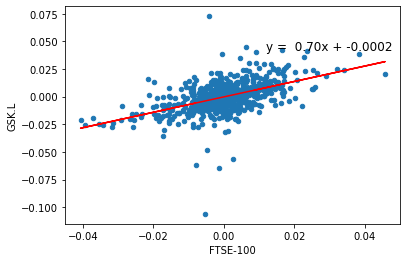

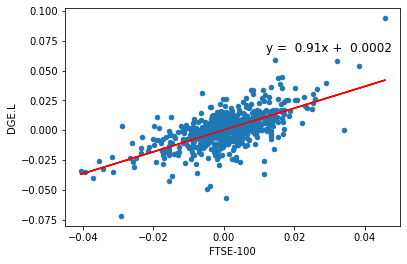

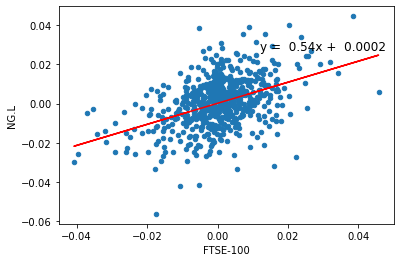

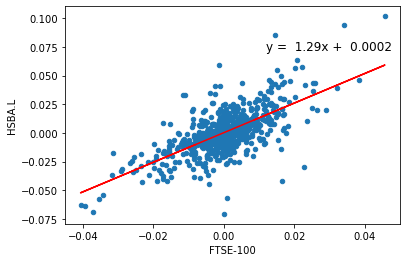

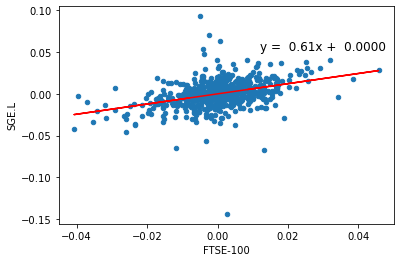

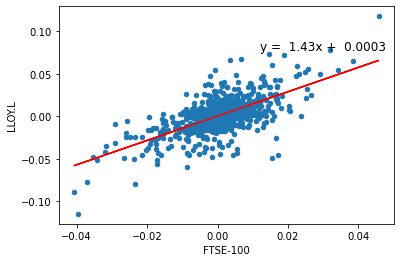

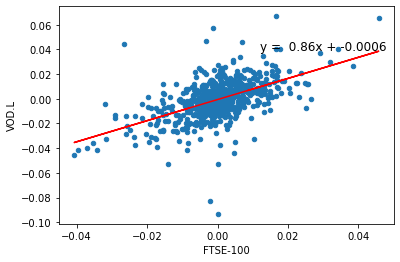

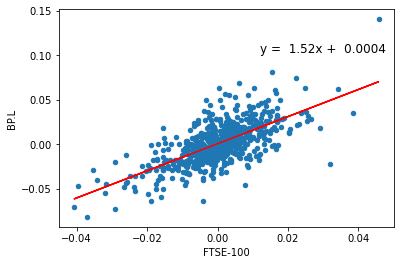

In [95]:
# Calculate Beta for a Portfolio of Stocks
# Beta and Alpha
# Alpha describes the strategy's ability to beat the market (FTSE-100)
# Need the daily log daily return with the FTSE-100
beta = {}
alpha = {}

for i in stocks_data.columns:
    if i != 'Date' and i != 'FTSE-100':
        stocks_data.plot(kind = 'scatter', x = 'FTSE-100', y = i)
        b, a = np.polyfit(stocks_data['FTSE-100'], stocks_data[i], 1)
        plt.plot(stocks_data['FTSE-100'], b * stocks_data['FTSE-100'] + a, '-', color = 'r')
        beta[i] = b
        alpha[i] = a
        equation = f'y = {b: .2f}x + {a: .4f}'
        plt.annotate(equation, (0.6, 0.8), xycoords='axes fraction', fontsize=12)
        plt.show()

In [96]:
# Beta for each stock
beta

{'ULVR.L': 0.47918942701530676,
 'AZN.L': 0.6763735175208946,
 'GSK.L': 0.6962770043833583,
 'DGE.L': 0.9138919346339246,
 'NG.L': 0.5376153592891187,
 'HSBA.L': 1.2913888952855517,
 'SGE.L': 0.6098795564889462,
 'LLOY.L': 1.4309358625780608,
 'VOD.L': 0.8556686250692939,
 'BP.L': 1.5237016118376339}

In [97]:
# Alpha of each stock
alpha

{'ULVR.L': -4.90874747231938e-05,
 'AZN.L': 0.0002860487526052764,
 'GSK.L': -0.00020543336453529996,
 'DGE.L': 0.0002054305282035891,
 'NG.L': 0.00018407843526433205,
 'HSBA.L': 0.00021741896925097336,
 'SGE.L': 3.417827788227969e-05,
 'LLOY.L': 0.0002948757152407935,
 'VOD.L': -0.000635037940509881,
 'BP.L': 0.0004033352668350769}

In [293]:
# Check performance of the portfolio from 30/11/2017 to 30/12/2022
# Stock prices in the period
period = pd.read_csv('total.csv', index_col=0)
period.head()

,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L
Date,,,,,,,,,,
30/11/17,3418.677002,4018.912109,916.172913,2237.934570,658.300232,545.147827,668.758423,48.295273,146.774628,353.872864
01/12/17,3378.447754,4010.498047,923.691345,2234.884766,658.300232,542.028442,663.145874,47.380589,146.578339,355.971130
04/12/17,3401.846436,3991.989502,924.049377,2253.617920,658.300232,544.330872,660.987305,47.841595,147.592606,356.694611
05/12/17,3412.929932,3972.639404,915.814941,2271.043945,655.101685,543.365356,660.987305,47.673294,147.396286,355.790192
06/12/17,3430.581299,3973.901367,915.098938,2301.975098,653.018921,538.389282,656.669861,47.424492,147.101807,357.598999


In [294]:
#Labels
labels = ['Unilever', 'AstraZeneca', 'GalaxoSmithKline', 'Diageo', 'National Grid', 'The Sage Group', 'HSBC Holdings',
'Lloyds Banking Group', 'Vodafone Group', 'BP']

In [295]:
# Portfolio 2
weight_p1 = total.iloc[56, 3:]

weightsp1 = weight_p1.values
weightsp1

array([0.01, 0.1 , 0.03, 0.05, 0.17, 0.18, 0.13, 0.12, 0.01, 0.2 ])

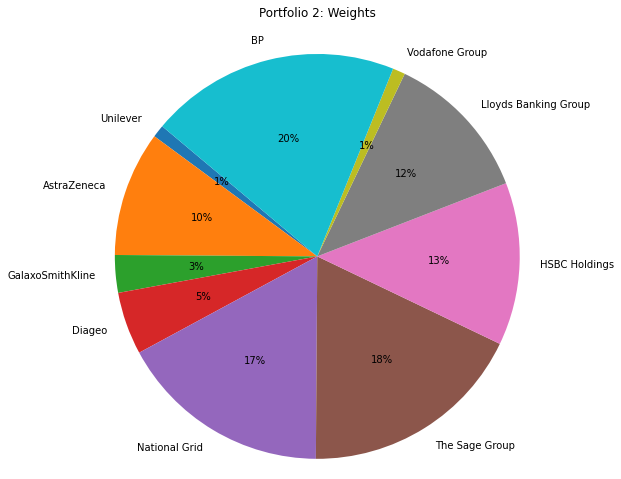

In [296]:
fig, ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('white')
ax.pie(weight_p1.values, labels=labels, autopct='%1.f%%', startangle=140)
ax.axis('equal')


ax.set_title('Portfolio 2: Weights', pad=20)
plt.show()

In [297]:
# Get the daily return of the portfolio
returns = period.pct_change()
portfolio_returnss = (returns * weightsp1).sum(axis=1)

portfolio_returnss

portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
30/11/17,30/11/17,0.000000
01/12/17,01/12/17,-0.003370
04/12/17,04/12/17,0.002023
05/12/17,05/12/17,-0.002421
06/12/17,06/12/17,-0.001926
...,...,...
22/12/22,22/12/22,-0.003623
23/12/22,23/12/22,-0.002940
28/12/22,28/12/22,0.006116


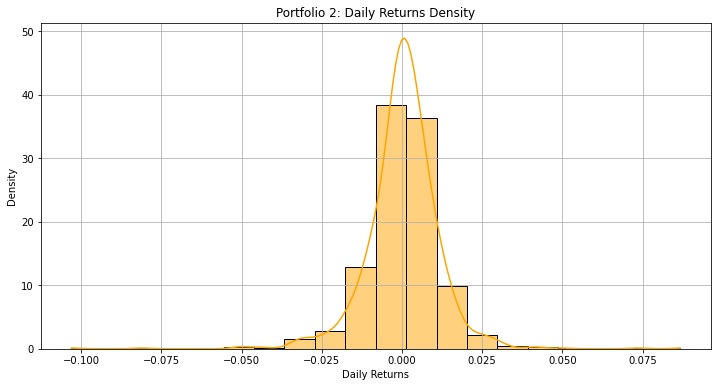

In [298]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='orange', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 2: Daily Returns Density')
plt.grid(True)
plt.show()

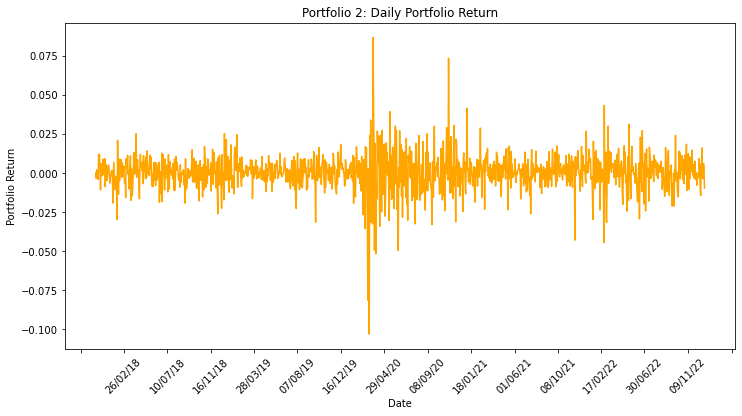

In [299]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='orange')

# Set the x-axis date format and display every Nth date
N = 3  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 2: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [300]:
# Average portfolio return
np.average(portfolio_performance['Portfolio_Return'])
average_return = (1+np.average(portfolio_performance['Portfolio_Return']))**252-1
average_return

0.08846846751126836

In [301]:
# Portfolio 1
weight_p2 = total.iloc[65, 3:]

weightsp2 = weight_p2.values
weightsp2

array([0.12, 0.16, 0.08, 0.07, 0.23, 0.06, 0.12, 0.02, 0.01, 0.13])

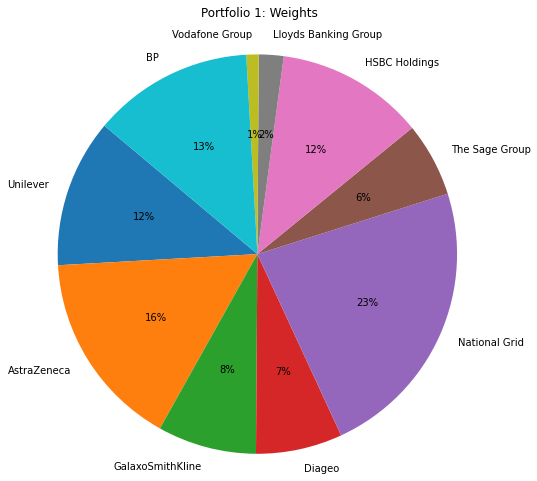

In [302]:
fig, ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('white')
ax.pie(weight_p2.values, labels=labels, autopct='%1.f%%', startangle=140)
ax.axis('equal')

ax.set_title('Portfolio 1: Weights', pad=20)
plt.show()

In [303]:
# Get the daily return of the portfolio
returns = period.pct_change()
portfolio_returnss = (returns * weightsp2).sum(axis=1)

portfolio_returnss

portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
30/11/17,30/11/17,0.000000
01/12/17,01/12/17,-0.002158
04/12/17,04/12/17,0.001103
05/12/17,05/12/17,-0.002193
06/12/17,06/12/17,0.000034
...,...,...
22/12/22,22/12/22,-0.003325
23/12/22,23/12/22,-0.003414
28/12/22,28/12/22,0.003875


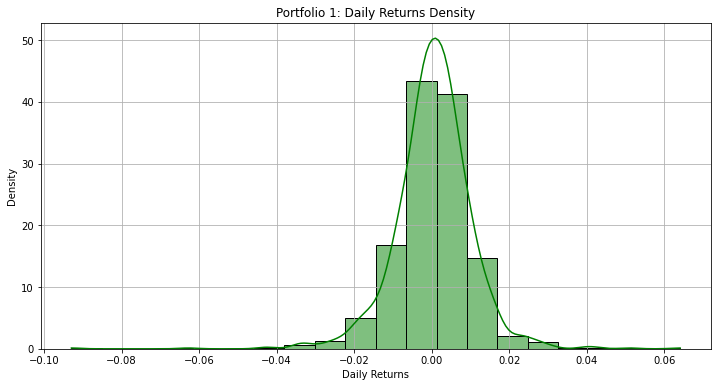

In [304]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='green', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 1: Daily Returns Density')
plt.grid(True)
plt.show()

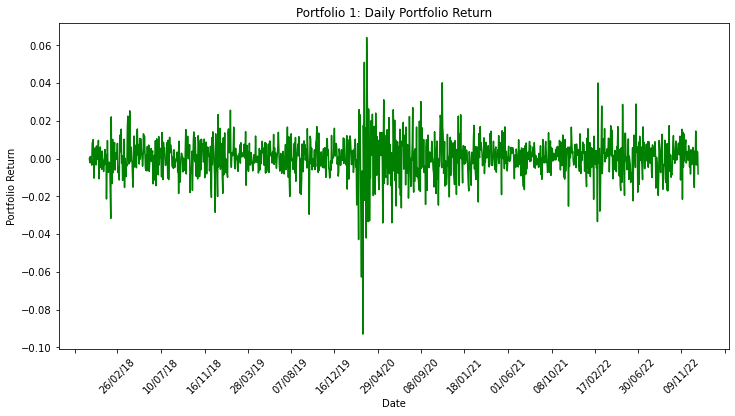

In [305]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='green')

# Set the x-axis date format and display every Nth date
N = 3  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 1: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [306]:
# Average annual portfolio return
np.average(portfolio_performance['Portfolio_Return'])
average_return = (1+np.average(portfolio_performance['Portfolio_Return']))**252-1
average_return

0.11033103146170231

In [307]:
# Portfolio 3
weight_p3 = total.iloc[70, 3:]

weightsp3 = weight_p3.values
weightsp3

array([0.03, 0.04, 0.02, 0.1 , 0.02, 0.25, 0.07, 0.27, 0.02, 0.19])

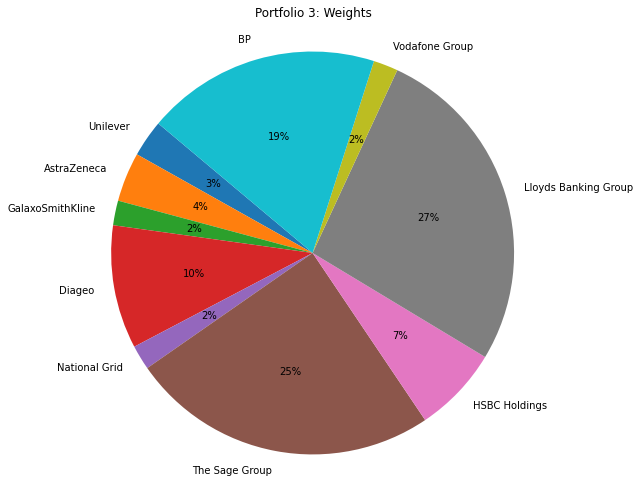

In [308]:
fig, ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('white')
ax.pie(weight_p3.values, labels=labels, autopct='%1.f%%', startangle=140)
ax.axis('equal')

ax.set_title('Portfolio 3: Weights', pad=20)
plt.show()

In [309]:
# Get the daily return of the portfolio
returns = period.pct_change()
portfolio_returnss = (returns * weightsp3).sum(axis=1)

portfolio_returnss

portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
30/11/17,30/11/17,0.000000
01/12/17,01/12/17,-0.006441
04/12/17,04/12/17,0.004855
05/12/17,05/12/17,-0.001500
06/12/17,06/12/17,-0.001779
...,...,...
22/12/22,22/12/22,-0.003317
23/12/22,23/12/22,-0.001942
28/12/22,28/12/22,0.006360


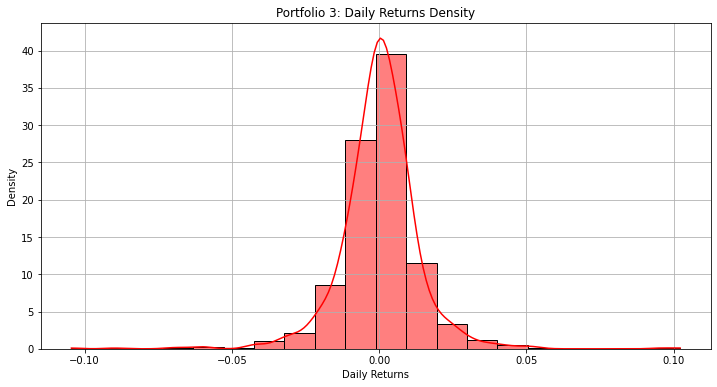

In [310]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='red', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 3: Daily Returns Density')
plt.grid(True)
plt.show()

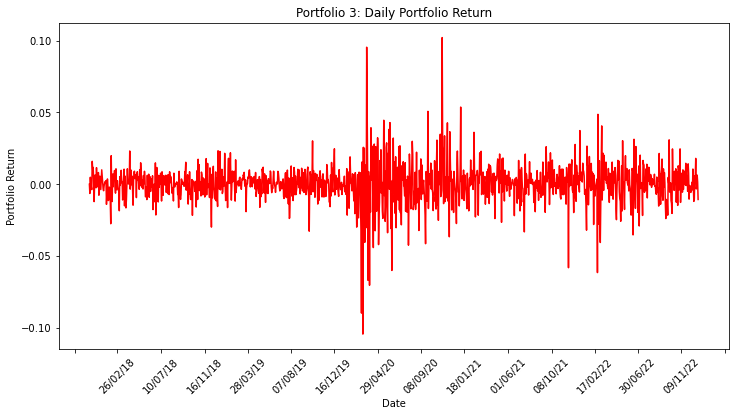

In [311]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='red')

# Set the x-axis date format and display every Nth date
N = 3  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 3: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [312]:
# Average portfolio return
np.average(portfolio_performance['Portfolio_Return'])
average_return = (1+np.average(portfolio_performance['Portfolio_Return']))**252-1
average_return

0.06515844575772811

In [313]:
# PERFORMANCE of the portfolios in the last-year
# 04/01/2022 to 30/08/2023
# Daily stock prices
last_year = pd.read_csv('last_year.csv', index_col=0)
last_year.head()

,ULVR.L,AZN.L,GSK.L,DGE.L,NG.L,HSBA.L,SGE.L,LLOY.L,VOD.L,BP.L
Date,,,,,,,,,,
04/01/22,3747.059326,8107.878418,1486.747192,3926.662598,993.846985,424.402222,802.646545,45.088898,99.971664,324.266510
05/01/22,3712.364746,8095.438477,1493.820679,3887.907715,980.571045,421.521881,802.837402,45.784523,99.087425,327.777161
06/01/22,3673.449707,7995.920410,1478.742798,3807.049316,972.089233,430.478027,786.998230,46.977013,98.810013,328.100464
07/01/22,3689.390625,8037.067383,1487.677979,3707.531250,971.536133,434.123444,786.998230,47.735874,99.347488,334.936829
10/01/22,3719.397217,7974.868652,1499.777344,3682.651611,971.167358,442.854492,770.204895,47.708775,101.826843,335.398773


In [314]:
# Get the daily return of the portfolio
returns = last_year.pct_change()
portfolio_returnss = (returns * weightsp1).sum(axis=1)

portfolio_returnss

portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
04/01/22,04/01/22,0.000000
05/01/22,05/01/22,-0.000130
06/01/22,06/01/22,0.000407
07/01/22,07/01/22,0.007020
10/01/22,10/01/22,0.000455
...,...,...
23/08/23,23/08/23,0.004931
24/08/23,24/08/23,0.004378
25/08/23,25/08/23,0.000160


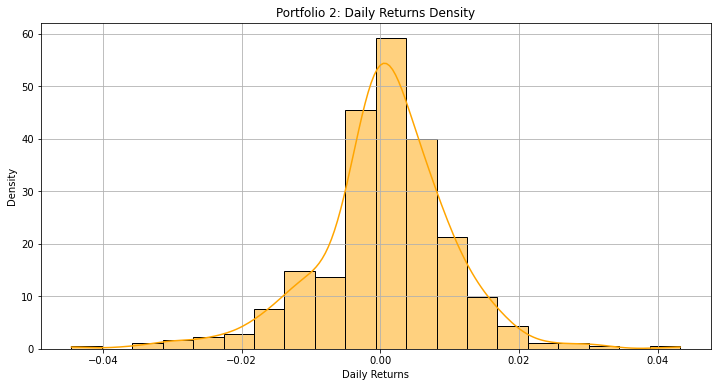

In [315]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='orange', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 2: Daily Returns Density')
plt.grid(True)
plt.show()

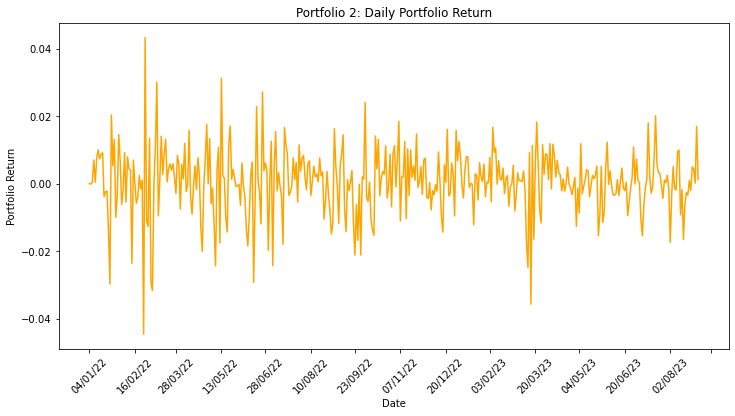

In [316]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='orange')

# Set the x-axis date format and display every Nth date
N = 1  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 2: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [317]:
# Average portfolio return
np.average(portfolio_performance['Portfolio_Return'])
average_return = (1+np.average(portfolio_performance['Portfolio_Return']))**252-1
average_return

0.15154795402194066

In [318]:
# Portfolio 2
# Get the daily return of the portfolio
portfolio_returnss = (returns * weightsp2).sum(axis=1)
portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
04/01/22,04/01/22,0.000000
05/01/22,05/01/22,-0.003490
06/01/22,06/01/22,-0.007949
07/01/22,07/01/22,0.003461
10/01/22,10/01/22,-0.001105
...,...,...
23/08/23,23/08/23,0.007712
24/08/23,24/08/23,0.004008
25/08/23,25/08/23,0.001440


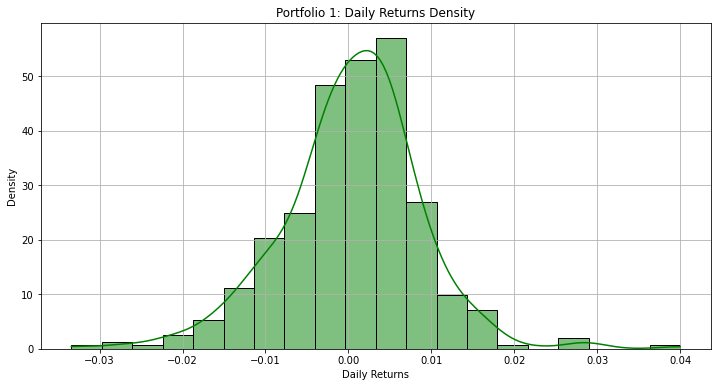

In [319]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='green', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 1: Daily Returns Density')
plt.grid(True)
plt.show()

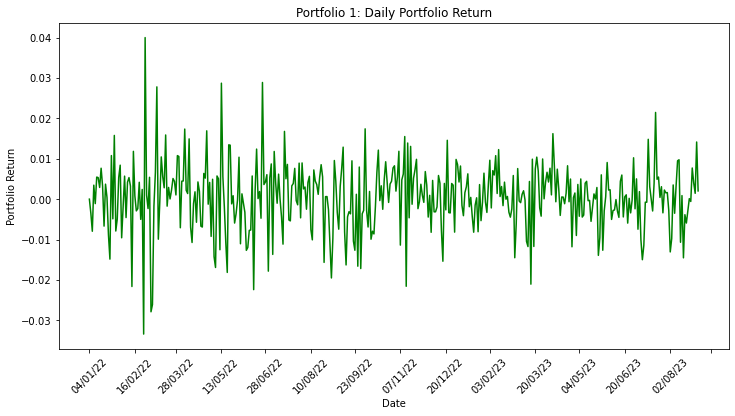

In [320]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='green')

# Set the x-axis date format and display every Nth date
N = 1  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 1: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [321]:
# Average portfolio return
np.average(portfolio_performance['Portfolio_Return'])
average_return = (1+np.average(portfolio_performance['Portfolio_Return']))**252-1
average_return

0.11353310459961374

In [322]:
# Portfolio 3
# Get the daily return of the portfolio
portfolio_returnss = (returns * weightsp3).sum(axis=1)
portfolio_performance = pd.DataFrame({'Date': portfolio_returnss.index, 'Portfolio_Return': portfolio_returnss})
portfolio_performance

,Date,Portfolio_Return
Date,,
04/01/22,04/01/22,0.000000
05/01/22,05/01/22,0.002867
06/01/22,06/01/22,0.007834
07/01/22,07/01/22,0.008378
10/01/22,10/01/22,0.003561
...,...,...
23/08/23,23/08/23,0.002406
24/08/23,24/08/23,0.005836
25/08/23,25/08/23,-0.001862


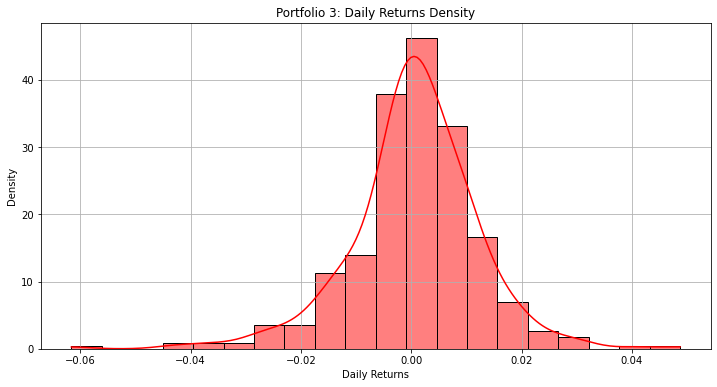

In [323]:
# Plot portfolio returns density with date (showing a subset of dates)
plt.figure(figsize=(12, 6))
sns.histplot(data=portfolio_performance['Portfolio_Return'], bins=20, kde=True, color='red', stat='density')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio 3: Daily Returns Density')
plt.grid(True)
plt.show()

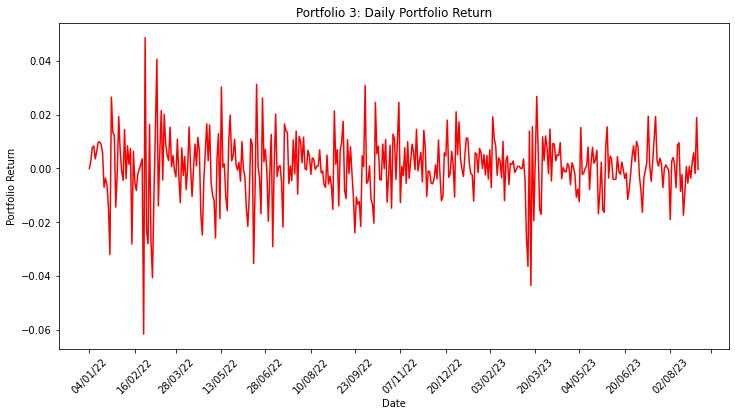

In [324]:
# Plot portfolio returns with date (showing a subset of dates)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_performance['Date'], portfolio_performance['Portfolio_Return'], color='red')

# Set the x-axis date format and display every Nth date
N = 1  # Change N to adjust the frequency of displayed dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=N))

plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio 3: Daily Portfolio Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()